In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sklearn.feature_extraction as ftex

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


#Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

# Bag of Words, Bag of Popcorn

[Bag of Words, Bag of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data) competition. 

NLP feature pre-processing (using SKLearn and NLTK) to build the best classifier possible with a feature pipeline, and gridsearch for the final model.

# 1. Importing Data

In [3]:
df=pd.read_csv("data/labeledTrainData.tsv", sep="\t")
df["ogreview"]=df.review


# 2. Data Cleaning 

In [4]:
#Automating the str.replace(exp1, exp2)
def cleanup(series, dic):
    for key in dic.keys():
        series=series.str.replace(key, dic[key], regex=False)

    return series

#List of strings to replace
to_replace={
    "<br /><br />" :"",
    "...": ".",
    "..": ".",
    '"': "",
    "'s": ""
}

df.review = df.review.str.lower()
df["text"]=cleanup(df.review, to_replace)



# 3. Modeling

Train-test split

In [ ]:
x, x_holdout,y, y_holdout = train_test_split(df.drop(columns=['sentiment']).text, df.sentiment, train_size=0.9, random_state=0)

Initializing the text vectorizer

In [ ]:
idf=ftex.text.TfidfVectorizer(stop_words="english", max_df=0.9, strip_accents="ascii")

#We can also use simple bag of word vectorizer, but it leads to slighlyt less accurate models
# vect=CountVectorizer(stop_words="english", min_df=5, max_df=0.9, strip_accents="ascii")

In [18]:
#Dictionary to save the model performance
model_scores={}

### 3.1 k-nearest neighbors classifier

In [111]:
#Setting up the pipeline
pipeline=Pipeline(
    [   #Preprocessing
        ("vect", idf),
        #ML modeling
        ('knn', KNeighborsClassifier()),
    ]
)

#parameters for the gridsearch
params_grid={
    'knn__n_neighbors': range(2,10) 
}

#Runnig the gridsearch 
grid=GridSearchCV(pipeline, param_grid=params_grid, scoring='accuracy', cv=5, n_jobs=5, verbose=3)
grid.fit(x,y)

print(grid.best_params_)
print(grid.best_score_)

#Saving the results on the holdout set
model_scores[(str(grid.best_estimator_).split("\n")[-1])] = accuracy_score(y_holdout, grid.best_estimator_.predict(x_holdout))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'knn__n_neighbors': 8}
0.7821777777777779


### 3.2 Naive Bayes classifier

In [46]:
#Setting up the pipeline
pipeline=Pipeline(
    [   #Preprocessing
        ("vect", idf),
        #ML modeling
        ('clf', MultinomialNB()),
    ]
)

#parameters for the gridsearch
params_grid={
    # 'vect__min_df' : np.arange(2,6),
    'vect__ngram_range': [(1,2)], #[(1,1),(1,2), (2,2)]
    
    'clf__alpha': [ 1, 1.5, 2] #[0.1, 0.5, 1, 1.5, 2, 3, 4, 5]
}

#Runnig the gridsearch 
grid=GridSearchCV(pipeline, param_grid=params_grid, scoring='accuracy', cv=5, n_jobs=5, verbose=3)
grid.fit(x,y)

print(grid.best_params_)
print(grid.best_score_)

#Saving the results
model_scores[(str(grid.best_estimator_).split("\n")[-1])] =accuracy_score(y_holdout, grid.best_estimator_.predict(x_holdout))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'clf__alpha': 1, 'vect__ngram_range': (1, 2)}
0.8726666666666667


### 3.3 Support Vector Classifier

In [35]:
#Setting up the pipeline
pipeline=Pipeline(
    [   #Preprocessing
        ("vect", idf),
        ('tsvd', TruncatedSVD()), 
        #ML modeling
        ('svc', SVC())
    ]
)

#parameters for the gridsearch
params_grid={
    'vect__min_df' : [2], #np.arange(2,6)
    'vect__ngram_range': [(1,2)], #(1,2) 
    'tsvd__n_components': [200], 

    'svc__gamma': [2],
    'svc__C' :[1]

}

#Runnig the gridsearch 
grid=GridSearchCV(pipeline, param_grid=params_grid, scoring='accuracy', cv=5, n_jobs=5, verbose=3)
grid.fit(x,y)

print(grid.best_params_)
print(grid.best_score_)

#Saving the results
model_scores[(str(grid.best_estimator_).split("\n")[-1])] =accuracy_score(y_holdout, grid.best_estimator_.predict(x_holdout))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'svc__C': 1, 'svc__gamma': 2, 'tsvd__n_components': 200, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}
0.8674222222222223


### 3.4 Decision Trees

In [30]:
#Setting up the pipeline
pipeline=Pipeline(
    [   #Preprocessing
        ("vect", idf),
        #ML modeling
        ('dtree', DecisionTreeClassifier()), 
    ]
)

#parameters for the gridsearch
params_grid={
    'vect__min_df' : [2], #np.arange(2,6)
    'vect__ngram_range': [(1,2)], #(1,2) 

    'dtree__random_state':[0]
}

#Runnig the gridsearch 
grid=GridSearchCV(pipeline, param_grid=params_grid, scoring='accuracy', cv=5, n_jobs=5, verbose=3)
grid.fit(x,y)

print(grid.best_params_)
print(grid.best_score_)

#Saving the results
model_scores[(str(grid.best_estimator_).split("\n")[-1])] =accuracy_score(y_holdout, grid.best_estimator_.predict(x_holdout))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'dtree__random_state': 0, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}
0.7095111111111111


### 3.5 Random forest classifier

In [ ]:
#Setting up the pipeline
pipeline=Pipeline(
    [   #Preprocessing
        ("vect", idf),
        #ML modeling
        ('randomf', RandomForestClassifier())
    ]
)

#parameters for the gridsearch
params_grid={
    # 'vect__min_df' : [2], #np.arange(2,6)
    # 'vect__ngram_range': [(1,2)], #(1,2) 
}

#Runnig the gridsearch 
grid=GridSearchCV(pipeline, param_grid=params_grid, scoring='accuracy', cv=5, n_jobs=5, verbose=3)
grid.fit(x,y)

print(grid.best_params_)
print(grid.best_score_)

#Saving the results
model_scores[(str(grid.best_estimator_).split("\n")[-1])] =accuracy_score(y_holdout, grid.best_estimator_.predict(x_holdout))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}
0.8452


### 3.6 NLTK Valence Aware Dictionary for Sentiment Reasoning (VADER Sentiment analysis) <br>
see:  https://www.nltk.org/_modules/nltk/sentiment/vader.html <br>

reference :Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [75]:
#Check if 'vader_lexicon' is downloaded
#and if not, download it

if 'nltk' not in sys.modules:
    import nltk
    nltk.download('vader_lexicon')

    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()

#Run vader's sentiment analysis
def vader(input):
    vader_out = input.apply(lambda review: sid.polarity_scores(review))
    scores=vader_out.apply(pd.Series)

    return scores

vd=vader(x)

plt.hist(vd.compound)

#0.8 seems to be the threshold for positive-negative sentiment that gives the best results on the train set 
vd["compound_binary"] = vd.compound.apply(lambda x: 1 if (x >= 0.8) else 0) 
print(f"Best accuracy: {accuracy_score(y, vd.compound_binary)}")

In [84]:
#Performing vader on the holdout set
vd=vader(x_holdout)
vd["compound_binary"] = vd.compound.apply(lambda x: 1 if (x >= 0.8) else 0) 

model_scores["                NLTK_vader"] =accuracy_score(y_holdout, vd.compound_binary)

# 4. Comparing the Different Models

Best model

In [118]:
max_key = max(model_scores, key=model_scores.get)
print(f"Best model tested: {max_key}")
print(f'Accuracy: {model_scores[max_key]}')

Best model tested:                 ('clf', MultinomialNB(alpha=1))])
Accuracy: 0.8726666666666667


Printing the values

In [ ]:
model_scores

{"                ('clf', MultinomialNB(alpha=1))])": 0.8726666666666667,
 "                ('knn', KNeighborsClassifier(n_neighbors=8))])": 0.7821777777777779,
 "                ('dtree', DecisionTreeClassifier(random_state=0))])": 0.7095111111111111,
 "                ('svc', SVC(C=1, gamma=2))])": 0.8674222222222223,
 "                ('randomf', RandomForestClassifier())])": 0.8452,
 '                NLTK_vader': 0.7392}

Plotting the different models accuracy scores

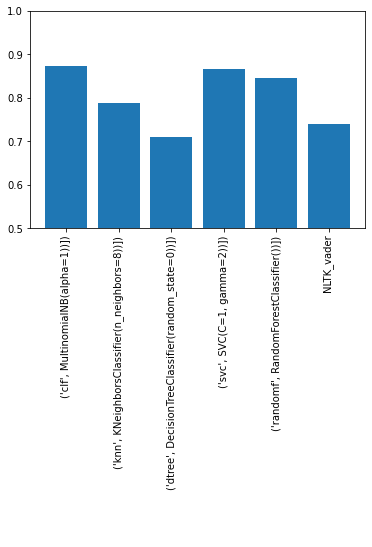

In [112]:
plt.bar(*zip(*model_scores.items()))
plt.xticks(rotation=90)
plt.ylim(0.5, 1)
plt.show()